# import library

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# merge data

In [2]:
data_path = '../../Dataset/BLE Data'

file_name = '4 day'

rssi_list = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16', '17','18','19','20', '21','22', '23','24','25']

mac_list = ['F7:7F:78:76:7E:F3',
            'C6:CD:5E:3D:2F:BB',
            'D6:F4:3A:79:74:63',
            'C9:17:55:E2:3E:0E',
            'CA:60:AB:EE:EC:7F',
            'D6:51:7F:AB:0E:29',
            'CC:54:33:F6:A7:90',
            'EB:20:56:87:04:5A',
            'EE:E7:46:DC:19:6F',
            'C8:5B:BF:37:07:A0',
            'D7:26:F6:A3:44:D2',
            'DD:83:B0:27:FD:36',
            'E5:CD:4A:36:87:06',
            'DC:22:B8:17:4E:B5',
            'EA:09:20:80:D6:44',
            'E6:99:D1:EC:C6:81',
            'F6:DA:97:C7:D5:28',
            'EA:66:A1:12:2C:F4',
            'C9:EA:57:8B:0F:80',
            'D6:7C:1D:2C:2A:0A',
            'DA:E1:70:5F:44:97',
            'DD:10:10:F6:4F:27',
            'E6:F3:93:A8:9E:22',
            'E6:60:05:1F:88:F9',
            'D4:33:FD:F4:C2:A8']

file_list = os.listdir(data_path)

csv_data = []
for csv_file in file_list:
  csv_data.append(pd.read_csv(os.path.join(data_path,csv_file),names=['user_id','timestamp','name', 'mac address', 'RSSI', 'power']))

df = csv_data[0]
for i in range(1,len(csv_data)):
  df = pd.concat([df,csv_data[i]])

print(df.shape)
df.head(5)

(5005751, 6)


,user_id,timestamp,name,mac address,RSSI,power
0,90,2023-04-10T10:22:55.589+0900,NaN,FD:07:0E:D5:28:AE,-75,-2147483648
1,90,2023-04-10T10:22:55.595+0900,NaN,FD:07:0E:D5:28:AE,-75,-2147483648
2,90,2023-04-10T10:22:55.601+0900,NaN,FD:07:0E:D5:28:AE,-75,-2147483648
3,90,2023-04-10T10:22:55.605+0900,NaN,FD:07:0E:D5:28:AE,-75,-2147483648
4,90,2023-04-10T10:22:55.609+0900,NaN,D2:1C:25:72:FB:E3,-62,-2147483648


In [4]:
df.to_csv('../../Dataset/df_concatenated.csv', index=False)

# load data

In [5]:
df = pd.read_csv('../../Dataset/df_concatenated.csv')
label = pd.read_csv('../../Dataset/5f_label_loc_train.csv')

# eda

In [6]:
print(df.info())

print(label.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5005751 entries, 0 to 5005750
Data columns (total 6 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   timestamp    object
 2   name         object
 3   mac address  object
 4   RSSI         int64 
 5   power        int64 
dtypes: int64(3), object(3)
memory usage: 229.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334 entries, 0 to 1333
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  1334 non-null   int64 
 1   Unnamed: 0    1334 non-null   int64 
 2   activity      1334 non-null   object
 3   started_at    1334 non-null   object
 4   finished_at   1334 non-null   object
 5   deleted_at    55 non-null     object
 6   updated_at    1334 non-null   object
 7   user_id       1334 non-null   int64 
 8   user          1334 non-null   object
 9   room          1332 non-null   object
 10  floor         1

## rssi

In [7]:
df.head(1)

,user_id,timestamp,name,mac address,RSSI,power
0,90,2023-04-10T10:22:55.589+0900,NaN,FD:07:0E:D5:28:AE,-75,-2147483648


In [8]:
print(df['user_id'].value_counts())
print(df['name'].value_counts())

user_id
90    5005751
Name: count, dtype: int64
name
Tile                      3302
AirPods_okokp             1843
ATH-CKS30TW               1790
AirPods                   1197
LE_ATH-CKS30TW             805
C60-E5F3                   494
Charge 5                   467
JBL CLUB PRO+ TWS-LE       338
vívoactive3                224
MOMENTUM TW 2              160
SMP72                      125
F2                          80
WHILL Service               60
TR8530 seri                 47
LE_LinkBuds                 45
20018A04663245GAD           42
GenioSan_009D6B5ECE7D       40
LG-PL7(5C)                  30
JBL Charge 5                30
ATJAutoDoor                 28
COTSUBU                     25
LE_WF-H800 (h.ear)          25
Square Reader 5754          20
Q9-PRO(ID-AD1D)             15
Chromecast8638              15
LE-SRS-XB13                 15
BT5.2 Mouse                 15
LE_WF-1000XM3               14
ATH-CK1TW_R#1000_WH         14
SPACER2762                  10
Mi Smart Band 6  

In [9]:
print(df['mac address'].nunique())
print(df['power'].nunique())
print(df['RSSI'].nunique())

4832
18
86


(array([4327327.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  678424.]),
 array([-2.14748365e+09, -1.93273528e+09, -1.71798691e+09, -1.50323854e+09,
        -1.28849018e+09, -1.07374181e+09, -8.58993441e+08, -6.44245073e+08,
        -4.29496706e+08, -2.14748338e+08,  3.00000000e+01]),
 <BarContainer object of 10 artists>)

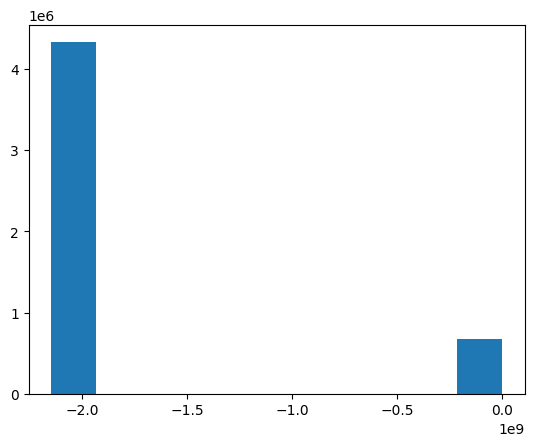

In [10]:
plt.hist(df['power'])

(array([  78335., 2096373.,  960440.,  762154.,  501673.,  427096.,
         104916.,   30658.,   32987.,   11119.]),
 array([-108. ,  -99.4,  -90.8,  -82.2,  -73.6,  -65. ,  -56.4,  -47.8,
         -39.2,  -30.6,  -22. ]),
 <BarContainer object of 10 artists>)

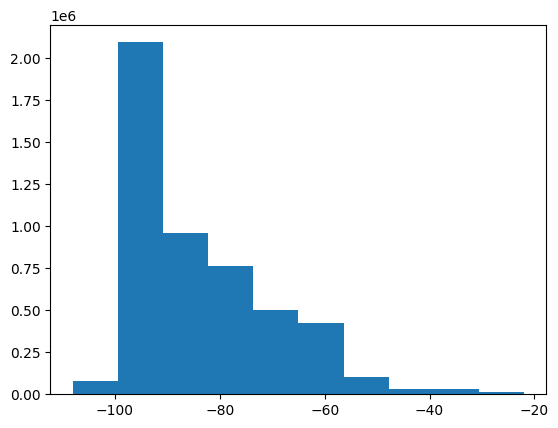

In [11]:
plt.hist(df['RSSI'])

## label

In [12]:
label.head(1)

,Unnamed: 0.1,Unnamed: 0,activity,started_at,finished_at,deleted_at,updated_at,user_id,user,room,floor
0,170,170,Location,2023-04-10 14:21:46+09:00,2023-04-10 14:21:50+09:00,NaN,2023-04-10 05:22:02 UTC,97,5th-location,kitchen,5th


In [13]:
print(label['activity'].value_counts())
print(label['user_id'].value_counts())
print(label['user'].value_counts())
print(label['room'].value_counts())
print(label['floor'].value_counts())

activity
Location            1325
就寝前食事                  2
朝食                     1
その他食事                  1
ANSIEL                 1
処置                     1
特記事項・連絡事項              1
おやつ                    1
ケア天気予報についてのアンケート       1
Name: count, dtype: int64
user_id
91    870
97    463
38      1
Name: count, dtype: int64
user
2nd-location            870
5th-location            463
sample  default user      1
Name: count, dtype: int64
room
hallway          239
Cafeteria D      204
cafeteria        129
Cafeteria A      109
Office Small     104
nurse station     98
Cafeteria B       91
kitchen           78
cleaning          28
Office Large      22
Clean Room        21
201               19
213               18
523               17
Cafeteria C       13
210                9
206                9
520                9
Bathroom           8
203                8
Nurse Room         8
513                6
522                6
202                6
207                6
517                5
508       

# preprocessing

## cleaning

In [14]:
df = df.drop(columns=['name'])

label = label.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'user', 'floor'])

In [15]:
# rename agar jelas
label = label.rename(columns={
    'started_at': 'start_time',
    'finished_at': 'stop_time'
})

# parse waktu
label['start_time'] = pd.to_datetime(label['start_time'], errors='coerce')
label['stop_time']  = pd.to_datetime(label['stop_time'], errors='coerce')

# hitung durasi
label['duration'] = (label['stop_time'] - label['start_time']).dt.total_seconds()

# filter valid
label = label[
    label['start_time'].notna() &
    label['stop_time'].notna() &
    (label['duration'] > 0) &
    label['deleted_at'].isna()
]

# hapus null penting & duplikat
label = label.dropna(subset=['room'])
label = label.drop_duplicates()

In [16]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df[df['timestamp'].notna()]

: 

: 

In [ ]:
df['timestamp'] = df['timestamp'].dt.tz_convert('Asia/Tokyo')
label['start_time'] = label['start_time'].dt.tz_convert('Asia/Tokyo')
label['stop_time'] = label['stop_time'].dt.tz_convert('Asia/Tokyo')

In [ ]:
label = label.loc[label['activity'] == 'Location']
label = label.drop(columns=['deleted_at', 'updated_at', 'activity'])

In [ ]:
df = df.sort_values('timestamp').reset_index(drop=True)
label = label.sort_values('start_time').reset_index(drop=True)

In [ ]:
# ambil rentang label
start_label = label['start_time'].min()
end_label = label['stop_time'].max()

# potong RSSI ke rentang label
df = df[(df['timestamp'] >= start_label) & (df['timestamp'] <= end_label)].copy()

print(df['timestamp'].min(), df['timestamp'].max())

2023-04-10 14:21:46.003000+09:00 2023-04-13 13:56:21.710000+09:00


In [ ]:
print(start_label)
print(end_label)

2023-04-10 14:21:46+09:00
2023-04-13 17:29:59+09:00


In [ ]:
rooms = []
lbl = label.to_dict('records')
j = 0
n = len(lbl)

for ts in df['timestamp']:
    # geser interval label sampai stop_time >= ts
    while j < n and ts > lbl[j]['stop_time']:
        j += 1

    if j < n and lbl[j]['start_time'] <= ts <= lbl[j]['stop_time']:
        rooms.append(lbl[j]['room'])
    else:
        rooms.append(np.nan)

df['room'] = rooms

# buang RSSI tanpa label
df1 = df.dropna(subset=['room']).reset_index(drop=True)


In [ ]:
print(df1.shape)
print(df1['room'].value_counts())

(2801370, 6)
room
nurse station    715904
Office Large     671342
Office Small     281160
kitchen          217449
cafeteria        202010
Cafeteria D      171031
hallway          116417
523               60060
208               56370
cleaning          41227
213               34870
513               25511
201               25175
210               23313
202               20227
Cafeteria A       18105
Cafeteria B       16606
520               13276
506               12235
501               10694
511               10022
Clean 9            7681
512                6550
522                6447
Clean Room         4645
515                4270
Cafeteria C        3972
206                3436
207                3297
Bathroom           3287
503                3104
508                3003
203                2393
212                2092
502                1649
516                1231
Nurse Room          723
510                 456
505                 100
518                  30
Name: count, dtype: in

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2801370 entries, 0 to 2801369
Data columns (total 6 columns):
 #   Column       Dtype                     
---  ------       -----                     
 0   user_id      int64                     
 1   timestamp    datetime64[ns, Asia/Tokyo]
 2   mac address  object                    
 3   RSSI         int64                     
 4   power        int64                     
 5   room         object                    
dtypes: datetime64[ns, Asia/Tokyo](1), int64(3), object(2)
memory usage: 128.2+ MB


In [ ]:
df1.to_csv('../../Dataset/df_cleaned.csv')

## feature engineering

In [3]:
df = pd.read_csv('../../Dataset/df_cleaned.csv')

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df[df['timestamp'].notna()]
df = df.drop(columns=['Unnamed: 0'])

In [6]:
mac_list = ['F7:7F:78:76:7E:F3',
            'C6:CD:5E:3D:2F:BB',
            'D6:F4:3A:79:74:63',
            'C9:17:55:E2:3E:0E',
            'CA:60:AB:EE:EC:7F',
            'D6:51:7F:AB:0E:29',
            'CC:54:33:F6:A7:90',
            'EB:20:56:87:04:5A',
            'EE:E7:46:DC:19:6F',
            'C8:5B:BF:37:07:A0',
            'D7:26:F6:A3:44:D2',
            'DD:83:B0:27:FD:36',
            'E5:CD:4A:36:87:06',
            'DC:22:B8:17:4E:B5',
            'EA:09:20:80:D6:44',
            'E6:99:D1:EC:C6:81',
            'F6:DA:97:C7:D5:28',
            'EA:66:A1:12:2C:F4',
            'C9:EA:57:8B:0F:80',
            'D6:7C:1D:2C:2A:0A',
            'DA:E1:70:5F:44:97',
            'DD:10:10:F6:4F:27',
            'E6:F3:93:A8:9E:22',
            'E6:60:05:1F:88:F9',
            'D4:33:FD:F4:C2:A8']

df = df[df['mac address'].isin(mac_list)]
df = df.sort_values('timestamp').reset_index(drop=True)

In [7]:
WINDOW = '45s'
df['window_start'] = df['timestamp'].dt.floor(WINDOW)

room_per_window = (
    df.groupby('window_start')['room']
      .nunique()
      .value_counts()
)

room_per_window

room
1    729
2    175
3     35
4      4
5      1
Name: count, dtype: int64

In [8]:
valid_windows = (
    df.groupby('window_start')['room']
      .nunique()
      .reset_index()
)

valid_windows = valid_windows[valid_windows['room'] == 1]['window_start']

df = df[df['window_start'].isin(valid_windows)].reset_index(drop=True)

df.groupby('window_start')['room'].nunique().value_counts()

room
1    729
Name: count, dtype: int64

In [9]:
# RSSI matrix: window x beacon
rssi_matrix = (
    df
    .groupby(['window_start', 'mac address'])['RSSI']
    .mean()              
    .unstack('mac address')
    .sort_index()
)

In [10]:
rssi_matrix

mac address,C6:CD:5E:3D:2F:BB,C8:5B:BF:37:07:A0,C9:17:55:E2:3E:0E,C9:EA:57:8B:0F:80,CA:60:AB:EE:EC:7F,CC:54:33:F6:A7:90,D4:33:FD:F4:C2:A8,D6:51:7F:AB:0E:29,D6:7C:1D:2C:2A:0A,D6:F4:3A:79:74:63,...,E5:CD:4A:36:87:06,E6:60:05:1F:88:F9,E6:99:D1:EC:C6:81,E6:F3:93:A8:9E:22,EA:09:20:80:D6:44,EA:66:A1:12:2C:F4,EB:20:56:87:04:5A,EE:E7:46:DC:19:6F,F6:DA:97:C7:D5:28,F7:7F:78:76:7E:F3
window_start,,,,,,,,,,,,,,,,,,,,,
2023-04-10 14:22:30+09:00,NaN,NaN,-94.812375,NaN,NaN,NaN,NaN,-96.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-10 14:24:45+09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-99.000000,NaN,NaN,NaN,NaN,-98.00
2023-04-10 14:25:30+09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-96.545455,NaN,-100.0,NaN,-96.213018,NaN,NaN,NaN,NaN,-96.75
2023-04-10 14:28:30+09:00,NaN,NaN,NaN,-91.780822,-93.512195,NaN,NaN,-93.522184,NaN,NaN,...,NaN,NaN,-99.0,NaN,NaN,NaN,NaN,-97.571429,-98.166667,NaN
2023-04-10 14:30:00+09:00,NaN,-91.714286,NaN,NaN,NaN,NaN,NaN,NaN,-86.200000,NaN,...,NaN,NaN,NaN,NaN,NaN,-97.500000,-92.428571,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-13 12:44:15+09:00,NaN,NaN,-89.833333,-96.363636,-95.000000,-95.000000,NaN,-90.500000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-97.000000,-97.000000,-94.136364,NaN,NaN
2023-04-13 12:45:00+09:00,NaN,NaN,-97.000000,NaN,NaN,NaN,NaN,-97.960000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-13 12:47:15+09:00,NaN,NaN,NaN,-98.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-95.000000,NaN,NaN


In [11]:
agg_funcs = ['mean', 'std', 'var', 'min', 'max', 'median', 'sum', 'count']

feat = (
    df
    .groupby(['window_start', 'room', 'mac address'])['RSSI']
    .agg(agg_funcs)
    .unstack('mac address')
)

# flatten kolom: {mac}_{stat}
feat.columns = [f'{mac}_{stat}' for stat, mac in feat.columns]
feat = feat.reset_index()

In [12]:
feat

,window_start,room,C6:CD:5E:3D:2F:BB_mean,C8:5B:BF:37:07:A0_mean,C9:17:55:E2:3E:0E_mean,C9:EA:57:8B:0F:80_mean,CA:60:AB:EE:EC:7F_mean,CC:54:33:F6:A7:90_mean,D4:33:FD:F4:C2:A8_mean,D6:51:7F:AB:0E:29_mean,...,E5:CD:4A:36:87:06_count,E6:60:05:1F:88:F9_count,E6:99:D1:EC:C6:81_count,E6:F3:93:A8:9E:22_count,EA:09:20:80:D6:44_count,EA:66:A1:12:2C:F4_count,EB:20:56:87:04:5A_count,EE:E7:46:DC:19:6F_count,F6:DA:97:C7:D5:28_count,F7:7F:78:76:7E:F3_count
0,2023-04-10 14:22:30+09:00,kitchen,NaN,NaN,-94.812375,NaN,NaN,NaN,NaN,-96.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-10 14:24:45+09:00,501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,17.0
2,2023-04-10 14:25:30+09:00,501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,187.0,NaN,34.0,NaN,169.0,NaN,NaN,NaN,NaN,68.0
3,2023-04-10 14:28:30+09:00,506,NaN,NaN,NaN,-91.780822,-93.512195,NaN,NaN,-93.522184,...,NaN,NaN,34.0,NaN,NaN,NaN,NaN,119.0,102.0,NaN
4,2023-04-10 14:30:00+09:00,520,NaN,-91.714286,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,34.0,119.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2023-04-13 12:44:15+09:00,Clean Room,NaN,NaN,-89.833333,-96.363636,-95.000000,-95.000000,NaN,-90.500000,...,NaN,NaN,NaN,NaN,NaN,24.0,6.0,132.0,NaN,NaN
725,2023-04-13 12:45:00+09:00,Clean Room,NaN,NaN,-97.000000,NaN,NaN,NaN,NaN,-97.960000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,2023-04-13 12:47:15+09:00,nurse station,NaN,NaN,NaN,-98.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN
727,2023-04-13 12:48:00+09:00,nurse station,NaN,NaN,-94.571429,-96.333333,-96.000000,-96.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,NaN


In [13]:
feat['hour'] = feat['window_start'].dt.hour
feat['minute'] = feat['window_start'].dt.minute
feat['second'] = feat['window_start'].dt.second

In [14]:
feat = feat.fillna(0)

# modelling

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold

from scipy.stats import mode
from imblearn.under_sampling import SMOTE
from collections import Counter

ImportError: cannot import name 'SMOTE' from 'imblearn.under_sampling' (d:\project\abc-challenge-2026\.venv\Lib\site-packages\imblearn\under_sampling\__init__.py)

In [16]:
X = feat.drop(columns=['window_start', 'room'])
y = feat['room']

In [17]:
X.columns = (
    X.columns
    .str.replace(':', '_', regex=False)
    .str.replace('-', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

In [22]:
min_samples = 7
valid_rooms = y.value_counts()[y.value_counts() >= min_samples].index

mask = y.isin(valid_rooms)
X = X[mask]
y = y[mask]

In [23]:
print(X.shape, y.shape)
X.iloc[:2, :5]
y.value_counts()

(698, 203) (698,)


room
nurse station    146
kitchen          127
Office Small      82
cafeteria         67
Cafeteria D       61
Office Large      39
hallway           31
523               31
201               17
513               16
213               13
520               12
512               11
208               11
210               10
522                9
Cafeteria B        8
cleaning           7
Name: count, dtype: int64

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.3,
    random_state=42,
    stratify=y_enc
)


### Oversampling

In [ ]:
#smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)
#X_train, y_train = smote.fit_resample(X_train, y_train)

### Undersampling

In [44]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42, replacement=False)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [45]:
models = {
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LR": LogisticRegression(max_iter=1000, n_jobs=-1),
    "HGBC": HistGradientBoostingClassifier(random_state=42)
}

models.update({
    "LGBM": lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(set(y_enc)),
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        random_state=42,
        allow_writing_files=False
    ),
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=len(set(y_enc)),
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        eval_metric='mlogloss',
        random_state=42,
        verbosity=0
    )
})

In [46]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0)
    })

In [47]:
results_df = pd.DataFrame(results).sort_values('f1_macro', ascending=False)
results_df

,model,accuracy,precision_macro,recall_macro,f1_macro
6,LGBM,0.657143,0.626599,0.566007,0.575556
5,HGBC,0.642857,0.506205,0.508119,0.499404
8,XGBoost,0.609524,0.487884,0.468358,0.472361
1,RF,0.604762,0.484140,0.480827,0.468400
7,CatBoost,0.638095,0.451275,0.496060,0.461636
0,DT,0.447619,0.432389,0.410203,0.385209
4,LR,0.428571,0.378770,0.386971,0.356880
2,SVM,0.409524,0.419448,0.388184,0.346594
3,KNN,0.357143,0.369172,0.406275,0.321261


### Voting

In [48]:
ensemble_keys = ['HGBC', 'XGBoost', 'LGBM', 'CatBoost']

probas_list = []
for name in ensemble_keys:
    model = models[name] 
    
    # Soft Voting
    probas = model.predict_proba(X_test)
    probas_list.append(probas)

In [49]:
avg_proba = np.mean(probas_list, axis=0)
y_pred_ensemble = np.argmax(avg_proba, axis=1)

print(f"Accuracy:  {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"F1 Macro:  {f1_score(y_test, y_pred_ensemble, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_ensemble, average='macro'):.4f}")


Accuracy:  0.6762
F1 Macro:  0.5685
Recall:    0.5703


In [50]:
preds_list = []

for name in ensemble_keys:
    model = models[name]
    
    # Hard Voting
    preds = model.predict(X_test)
    preds_list.append(preds)

In [51]:
all_preds = np.column_stack(preds_list)
majority_vote_result = mode(all_preds, axis=1)

if hasattr(majority_vote_result, 'mode'):
    y_pred_hard = majority_vote_result.mode.flatten()
else:
    y_pred_hard = majority_vote_result[0].flatten()

In [52]:
print(f"Accuracy:  {accuracy_score(y_test, y_pred_hard):.4f}")
print(f"F1 Macro:  {f1_score(y_test, y_pred_hard, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_hard, average='macro'):.4f}")

Accuracy:  0.6619
F1 Macro:  0.5289
Recall:    0.5439
